## Automatic Metaphor Detection

Given a fragment of text that has a metaphor keyword in it, predict whether that fragment is actually metaphorical.

In [1]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import pandas as pd

from tqdm import tqdm_notebook as tqdm

from allennlp.commands.elmo import ElmoEmbedder

from nltk.tokenize import RegexpTokenizer

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/allennlp/commands/find_learning_rate.py:42: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/alex/anaconda3/envs/nlp/lib/py

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
instances = pd.read_csv(op.join(DATA_PROCESSED, 'labeled.csv')).dropna()

len(instances)

1092

Load up an ELMO embedder for contextualized word embeddings.

In [4]:
elmo = ElmoEmbedder()
tokenizer = RegexpTokenizer(r'\w+')

In [5]:
instances.sample(3)

,char_location,fragment,keyword,kw_start,metaphorical,project_id,type
1415,1722.0,ed. We want Sean and his family to remain hope...,beating,81.0,True,afb2e3822e4a98c8acaa04f7594303fd,battle
1326,863.0,"g all of you, my friends and family to please...",fight,81.0,True,5606b6859928428dbb5f1b05fcc2031b,battle
1113,1129.0,"ly offering their help, and that has no moneta...",beating,81.0,True,80e2ab2a1c4b6402999631ddc740c196,battle


In [6]:
def pad(s, kw_start, lim=20):
    '''
    Limit a fragment to `lim` tokens. If less than, pad with empty strings.
    '''
    
    prior = tokenizer.tokenize(s[:kw_start])
    post = tokenizer.tokenize(s[kw_start:])
    
    if len(prior) < lim/2:
        while len(prior) < lim/2:
            prior.insert(0, '')
    else:
        prior = prior[len(prior) - round(lim/2):]
        
    if len(post) < lim/2:
        while len(post) < lim/2:
            post.append('')
    else:
        post = post[:round(lim/2)]
        
    prior.extend(post)
    return prior

In [7]:
fragments = [pad(fragment.fragment, int(fragment.kw_start)) for fragment in instances[['fragment', 'kw_start']].itertuples()]

Embed the fragment sequences with ELMO

In [8]:
embds = elmo.embed_sentences(fragments)
embedded_fragments = np.array([embd[2] for embd in tqdm(embds)])

In [9]:
embedded_fragments.shape

(1092, 20, 1024)

In [10]:
y_data = instances['metaphorical'].astype(int).values

# Keras

In [11]:
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras import optimizers

from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics

from datetime import datetime

Using TensorFlow backend.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(embedded_fragments, y_data, train_size=0.8, stratify=y_data)

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    return 2*((p*r)/(p+r+K.epsilon()))

Based on *Detecting Figurative Word Occurrences Using Recurrent Neural Networks* (Mykowiecka et al. 2018)

In [14]:
def build_model1():

    inputs = Input(shape=(20, 1024), name="input")

    x = GRU(20, name="gru")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(20, activation='relu', name="dense")(x)
    
    predictions = Dense(2, activation='softmax', name="out")(x)
    _model = Model(inputs=inputs, outputs=predictions)

    _model.compile(optimizer=optimizers.Adam(lr=0.5*1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=[f1])
    
    return _model

def build_model2():

    inputs = Input(shape=(20, 1024), name="input")

    x = LSTM(20, name="lstm")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(20, activation='relu', name="dense")(x)
    
    predictions = Dense(2, activation='softmax', name="out")(x)
    _model = Model(inputs=inputs, outputs=predictions)

    _model.compile(optimizer=optimizers.Adam(lr=0.5*1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=[f1])
    
    return _model

def build_model3():

    inputs = Input(shape=(20, 1024), name="input")

    x = Bidirectional(GRU(20, return_sequences=True, name="gru"))(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(20, name='gru2'))(x)

    x = Dropout(0.1)(x)
    x = Dense(20, activation='relu', name="dense")(x)
        
    predictions = Dense(2, activation='softmax', name="out")(x)
    _model = Model(inputs=inputs, outputs=predictions)

    _model.compile(optimizer=optimizers.Adam(lr=0.5*1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=[f1])
    
    return _model

def build_model4():

    inputs = Input(shape=(20, 1024), name="input")

    x = Bidirectional(LSTM(20, return_sequences=True, name="lstm"))(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(20, name='lstm2'))(x)

    x = Dropout(0.1)(x)
    x = Dense(20, activation='relu', name="dense")(x)
        
    predictions = Dense(2, activation='softmax', name="out")(x)
    _model = Model(inputs=inputs, outputs=predictions)

    _model.compile(optimizer=optimizers.Adam(lr=0.5*1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=[f1])
    
    return _model

In [15]:
build_model4().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 40)            167200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                9760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                820       
_________________________________________________________________
out (Dense)                  (None, 2)                 42        
Total para

In [16]:
CONF_THRES = 0.9

In [17]:
results = pd.read_csv(op.join(DATA_PROCESSED, 'neural_net_results2.csv'))
results.tail()

,model,trial,weight,epochs,fold,low confidence,precision,recall,auc,mcc
205,2,2,25.0,15,2,0.352941,0.868852,0.815385,0.707692,0.391428
206,3,2,25.0,15,2,0.182353,0.854015,0.900000,0.700000,0.428987
207,4,2,25.0,15,2,0.117647,0.845070,0.923077,0.686538,0.426655
208,1,2,25.0,15,3,0.570588,0.876190,0.713178,0.698053,0.348695
209,2,2,25.0,15,3,0.794118,0.895238,0.728682,0.730195,0.405285


In [18]:
# Takes a long time. Results should be 180 (180 total iterations)

# results = []

kfold = KFold(n_splits=5, shuffle=True)

for trial in [3]:
    for weight in [25., 50., 75.]:
        for epochs in [10, 15]: # 20
            for fold, (train_ixs, val_ixs) in enumerate(kfold.split(X_train)):

                for model_ix, model in enumerate([build_model1(), build_model2(), build_model3(), build_model4()]):

                    print(f'[{datetime.now()}] Model: {model_ix+1} Weight: {weight} Epochs: {epochs} Trial: {trial+1} Fold: {fold+1}')

                    weights = {0: weight, 1: 1.0}

                    history = model.fit(X_train[train_ixs], y_train[train_ixs], epochs=epochs, class_weight=weights, verbose=0)

                    probs = model.predict(X_train[val_ixs])
                    preds = probs.argmax(axis=1)

                    low_conf = sum(probs.max(axis=1) < CONF_THRES) / len(val_ixs)

                    precision = metrics.precision_score(  y_train[val_ixs], preds)
                    recall =    metrics.recall_score(     y_train[val_ixs], preds)
                    auc =       metrics.roc_auc_score(    y_train[val_ixs], preds)
                    mcc =       metrics.matthews_corrcoef(y_train[val_ixs], preds)
                    
                    results = results.append({'model': model_ix+1, 
                                              'trial': trial+1, 
                                              'weight': weight, 
                                              'epochs': epochs, 
                                              'fold': fold+1, 
                                              'low confidence': low_conf, 
                                              'precision': precision, 
                                              'recall': recall, 
                                              'auc': auc, 
                                              'mcc': mcc}, sort=False, ignore_index=True)

[2019-02-10 17:47:56.083540] Model: 1 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 1
[2019-02-10 17:48:04.925023] Model: 2 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 1
[2019-02-10 17:48:14.875580] Model: 3 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 1
[2019-02-10 17:48:34.378920] Model: 4 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 1
[2019-02-10 17:49:01.110443] Model: 1 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 2
[2019-02-10 17:49:10.557618] Model: 2 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 2
[2019-02-10 17:49:21.219797] Model: 3 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 2
[2019-02-10 17:49:43.632159] Model: 4 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 2
[2019-02-10 17:50:13.317497] Model: 1 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 3
[2019-02-10 17:50:24.817164] Model: 2 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 3
[2019-02-10 17:50:36.963162] Model: 3 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 3
[2019-02-10 17:51:01.100686] Model: 4 Weight: 25.0 Epochs: 10 Trial: 4 Fold: 3
[2019-02-10 17:51:33.092977] Model: 1 Weight: 25.0 E

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 18:14:17.092709] Model: 2 Weight: 50.0 Epochs: 10 Trial: 4 Fold: 5


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 18:14:50.197206] Model: 3 Weight: 50.0 Epochs: 10 Trial: 4 Fold: 5
[2019-02-10 18:15:32.641559] Model: 4 Weight: 50.0 Epochs: 10 Trial: 4 Fold: 5
[2019-02-10 18:16:21.555924] Model: 1 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 18:16:55.306207] Model: 2 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 18:17:31.614338] Model: 3 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 18:18:20.290815] Model: 4 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 18:19:18.613297] Model: 1 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 2
[2019-02-10 18:19:59.840772] Model: 2 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 2
[2019-02-10 18:20:37.399337] Model: 3 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 2
[2019-02-10 18:21:28.368005] Model: 4 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 2
[2019-02-10 18:22:26.099150] Model: 1 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 3
[2019-02-10 18:23:00.494700] Model: 2 Weight: 50.0 Epochs: 15 Trial: 4 Fold: 3
[2019-02-10 18:23:40.665979] Model: 3 Weight: 50.0 E

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:07:31.356839] Model: 2 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 1


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:08:17.212013] Model: 3 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 1
[2019-02-10 19:09:23.952696] Model: 4 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 1
[2019-02-10 19:10:22.759110] Model: 1 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 2
[2019-02-10 19:11:11.587019] Model: 2 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 2


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:11:51.476447] Model: 3 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 2


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:12:40.564155] Model: 4 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 2


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:14:16.114712] Model: 1 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 3


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:14:56.071409] Model: 2 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 3


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:15:44.913505] Model: 3 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 3
[2019-02-10 19:16:50.985853] Model: 4 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 3
[2019-02-10 19:18:03.400716] Model: 1 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 4
[2019-02-10 19:18:47.545038] Model: 2 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 4


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:19:34.266880] Model: 3 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 4
[2019-02-10 19:20:36.904918] Model: 4 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 4
[2019-02-10 19:21:48.508336] Model: 1 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 5
[2019-02-10 19:22:31.771649] Model: 2 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 5
[2019-02-10 19:23:16.031682] Model: 3 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 5


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:24:11.490109] Model: 4 Weight: 75.0 Epochs: 10 Trial: 4 Fold: 5
[2019-02-10 19:25:15.943786] Model: 1 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 19:26:05.893026] Model: 2 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 19:27:01.016985] Model: 3 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 19:28:12.596260] Model: 4 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 1
[2019-02-10 19:29:45.018961] Model: 1 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 2


/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:30:52.943655] Model: 2 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 2
[2019-02-10 19:31:52.185356] Model: 3 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 2
[2019-02-10 19:33:00.677915] Model: 4 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 2
[2019-02-10 19:34:19.026903] Model: 1 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 3
[2019-02-10 19:36:09.516899] Model: 2 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 3
[2019-02-10 19:37:04.939906] Model: 3 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 3
[2019-02-10 19:38:14.221411] Model: 4 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 3
[2019-02-10 19:39:35.083516] Model: 1 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 4
[2019-02-10 19:40:31.068956] Model: 2 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 4
[2019-02-10 19:41:30.141219] Model: 3 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 4
[2019-02-10 19:42:40.585865] Model: 4 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 4
[2019-02-10 19:44:01.194082] Model: 1 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 5
[2019-02-10 19:44:55.954001] Model: 2 Weight: 75.0 E

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[2019-02-10 19:45:52.600577] Model: 3 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 5
[2019-02-10 19:47:02.102937] Model: 4 Weight: 75.0 Epochs: 15 Trial: 4 Fold: 5


In [21]:
# results = pd.DataFrame(results, columns=['model', 'trial', 'weight', 'epochs', 'fold', 'low confidence', 'precision', 'recall', 'auc', 'mcc'])
results.to_csv(op.join(DATA_PROCESSED, 'neural_net_results2.csv'), index=False)

In [26]:
results['trial'].value_counts()

1.0    180
4.0    120
2.0     30
Name: trial, dtype: int64

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


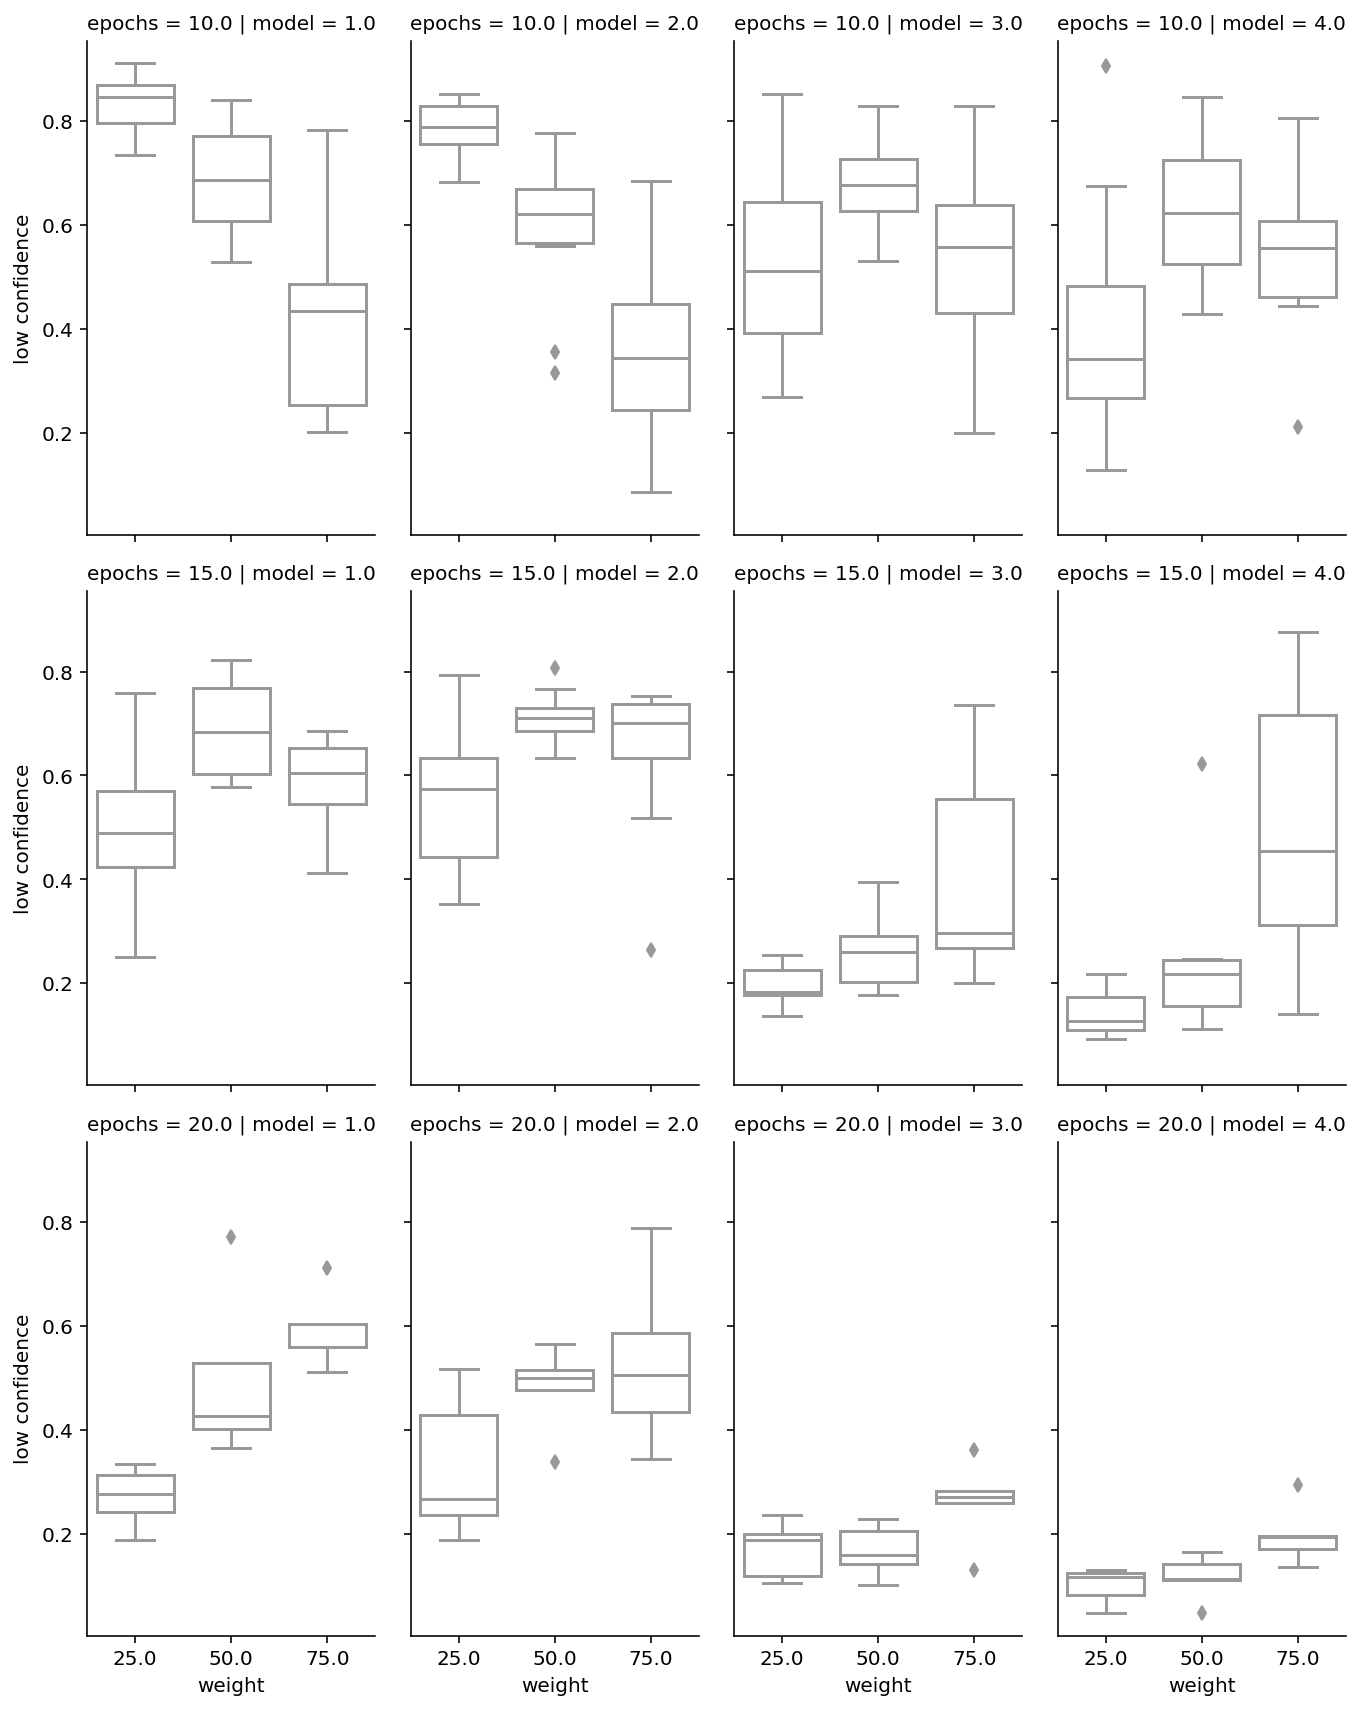

In [28]:
g = sns.FacetGrid(results, col='model', row='epochs', sharey=True, height=4, aspect=0.6)
g = g.map(sns.boxplot, 'weight', 'low confidence', color='w')

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


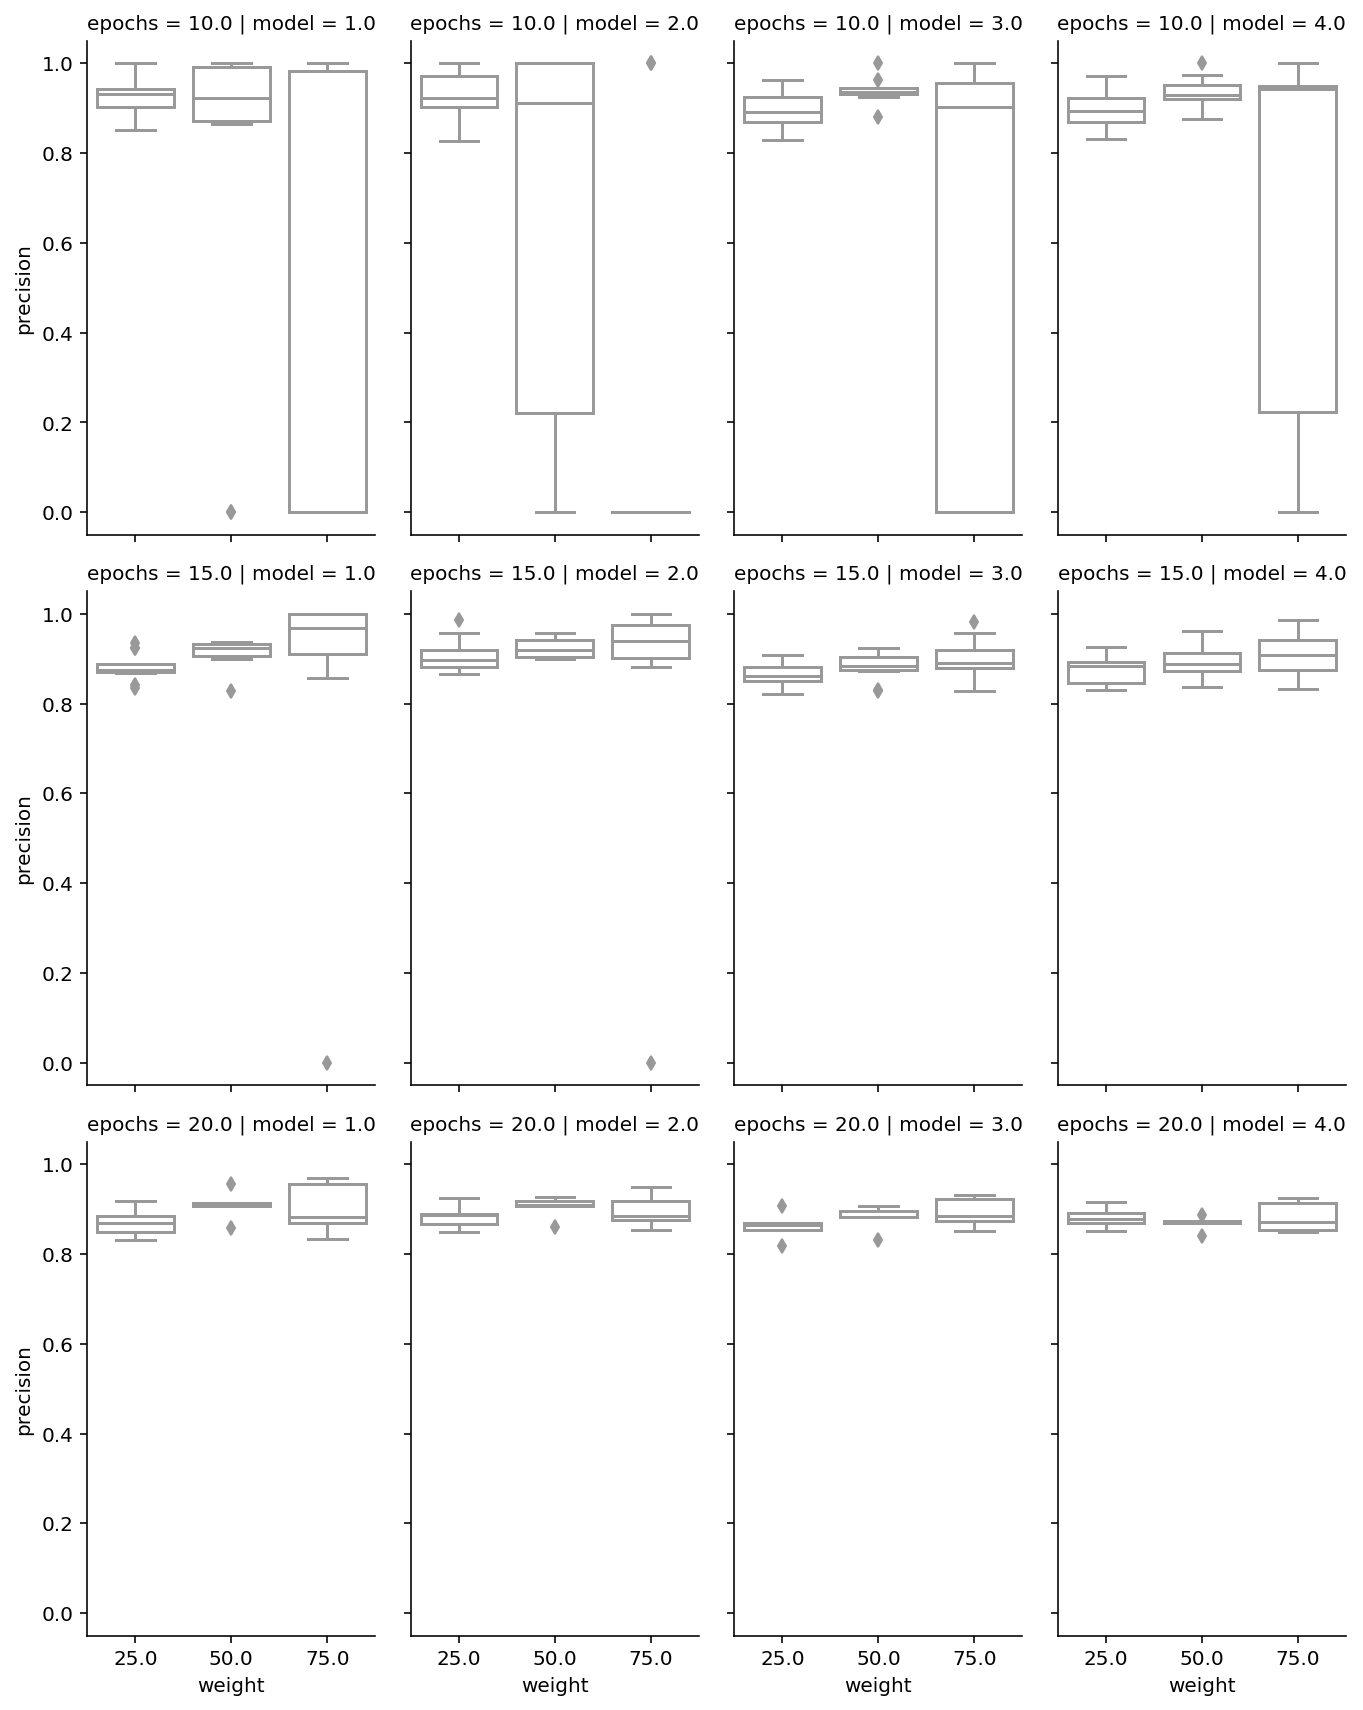

In [29]:
g = sns.FacetGrid(results, col='model', row='epochs', sharey=True, height=4, aspect=0.6)
g = g.map(sns.boxplot, 'weight', 'precision', color='w')

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


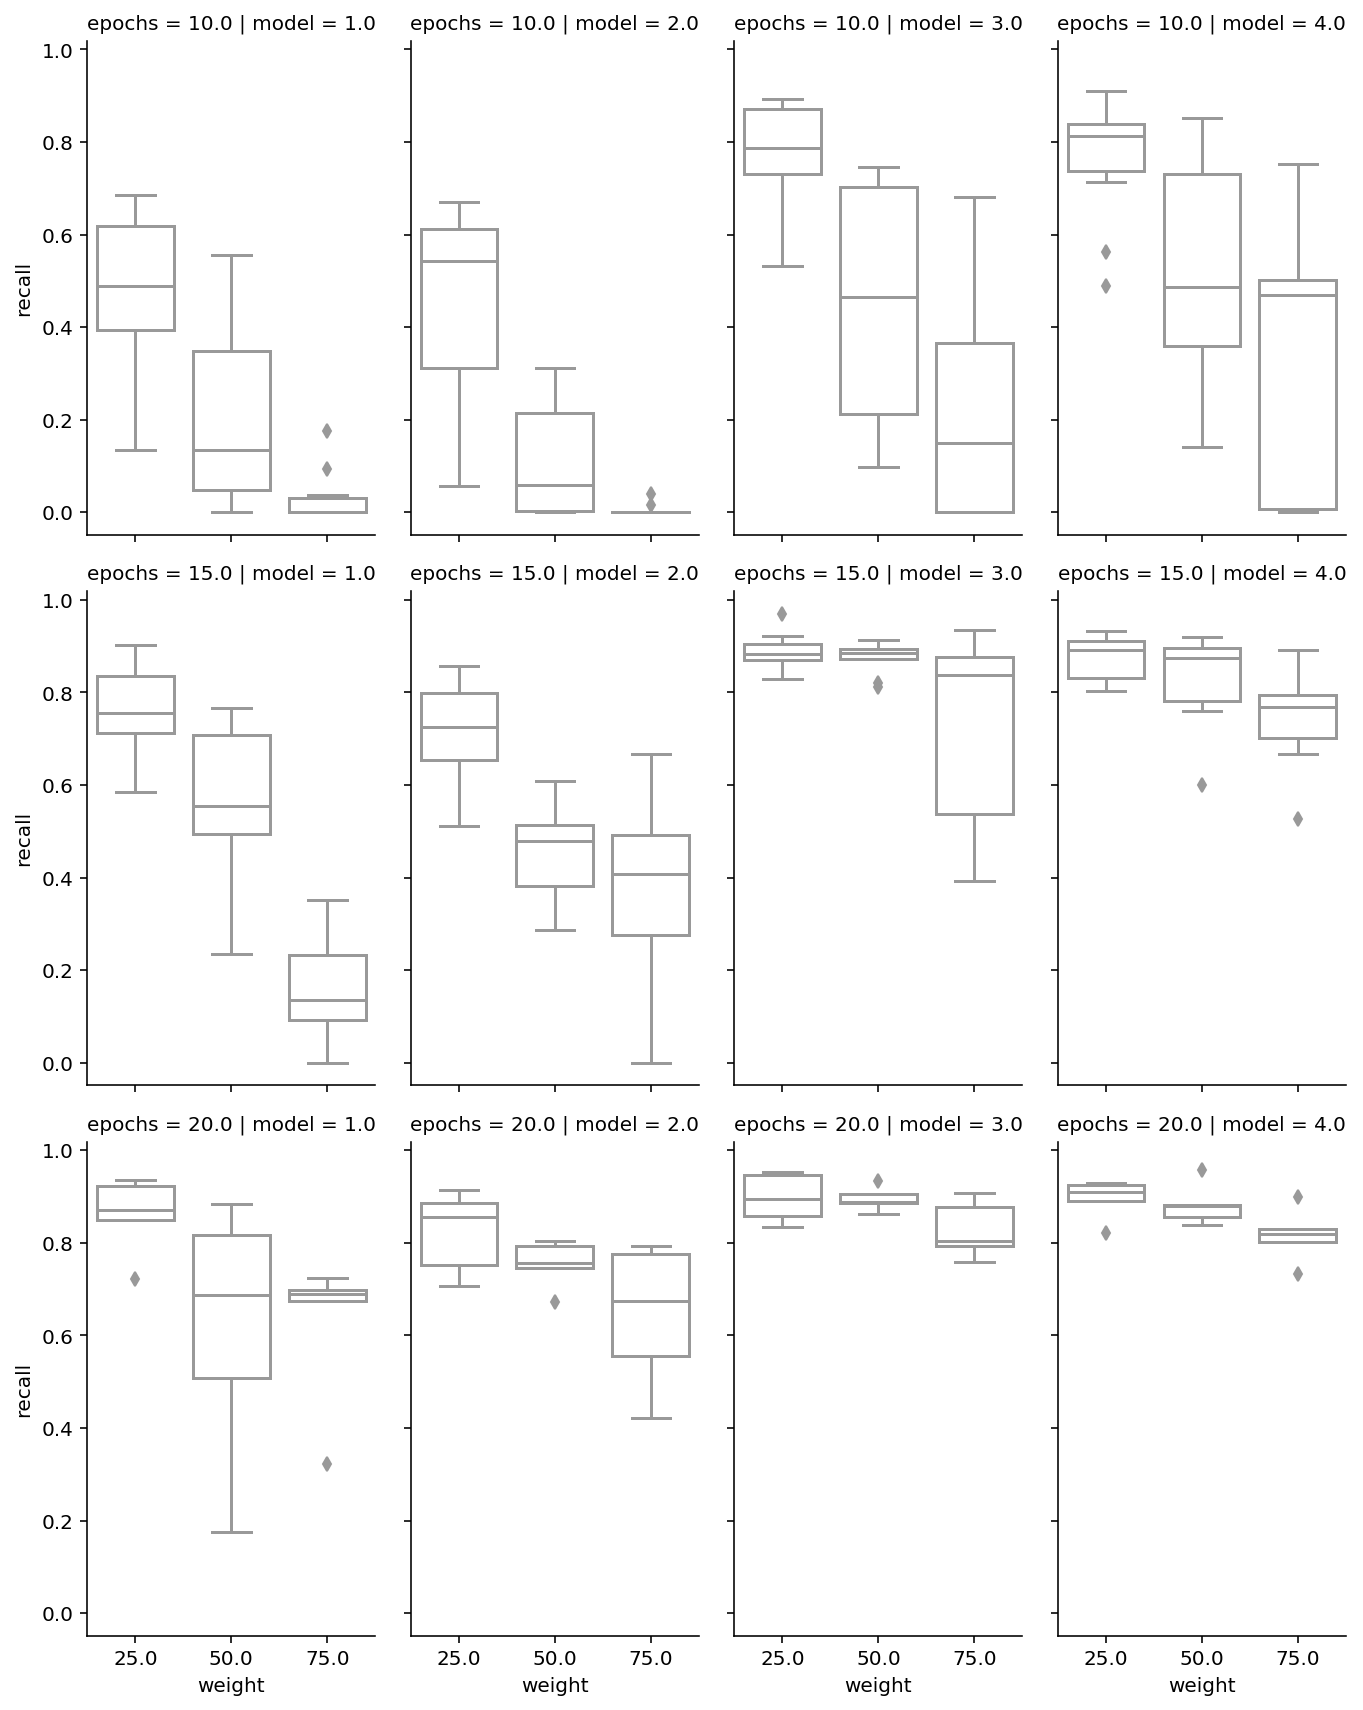

In [30]:
g = sns.FacetGrid(results, col='model', row='epochs', sharey=True, height=4, aspect=0.6)
g = g.map(sns.boxplot, 'weight', 'recall', color='w')

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


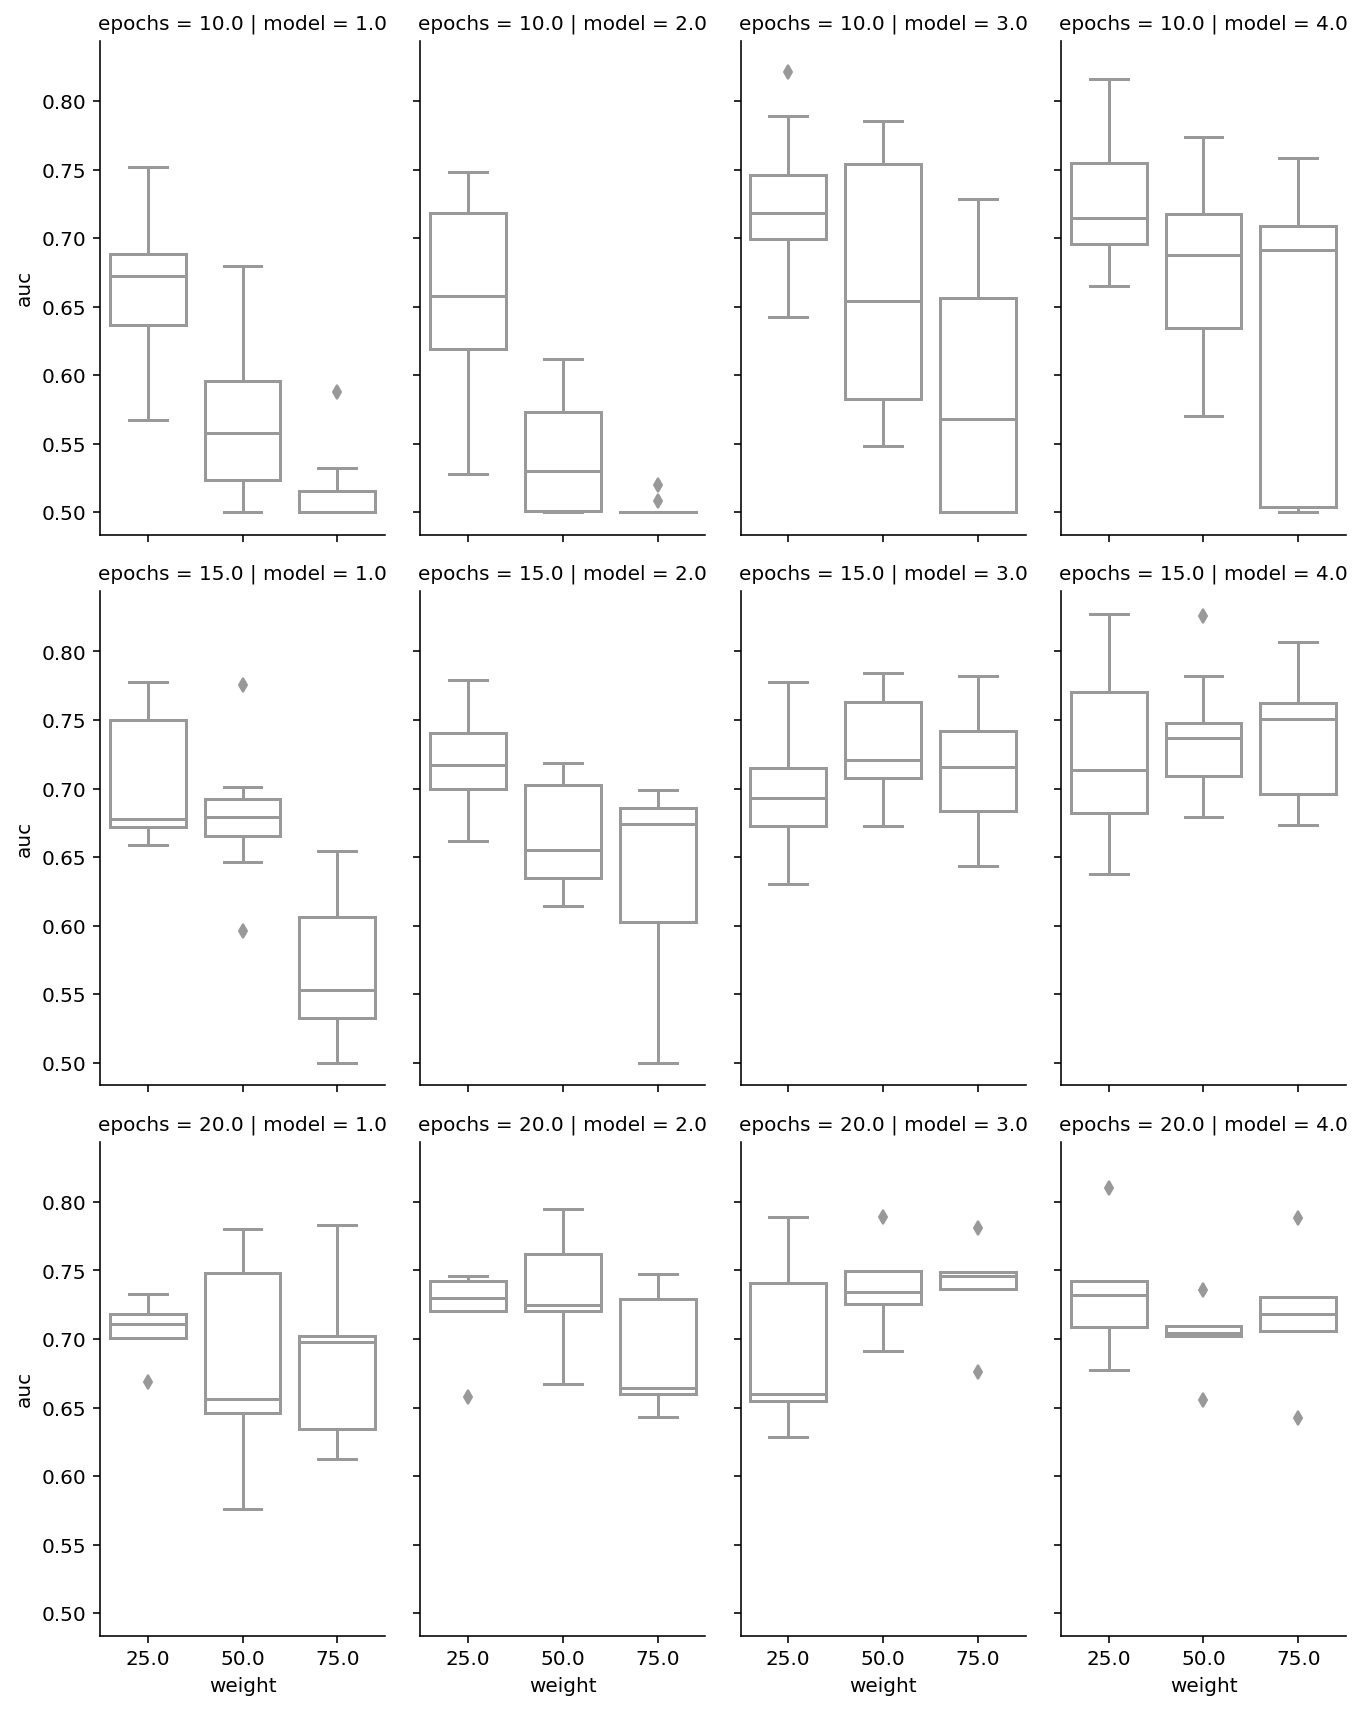

In [31]:
g = sns.FacetGrid(results, col='model', row='epochs', sharey=True, height=4, aspect=0.6)
g = g.map(sns.boxplot, 'weight', 'auc', color='w')

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


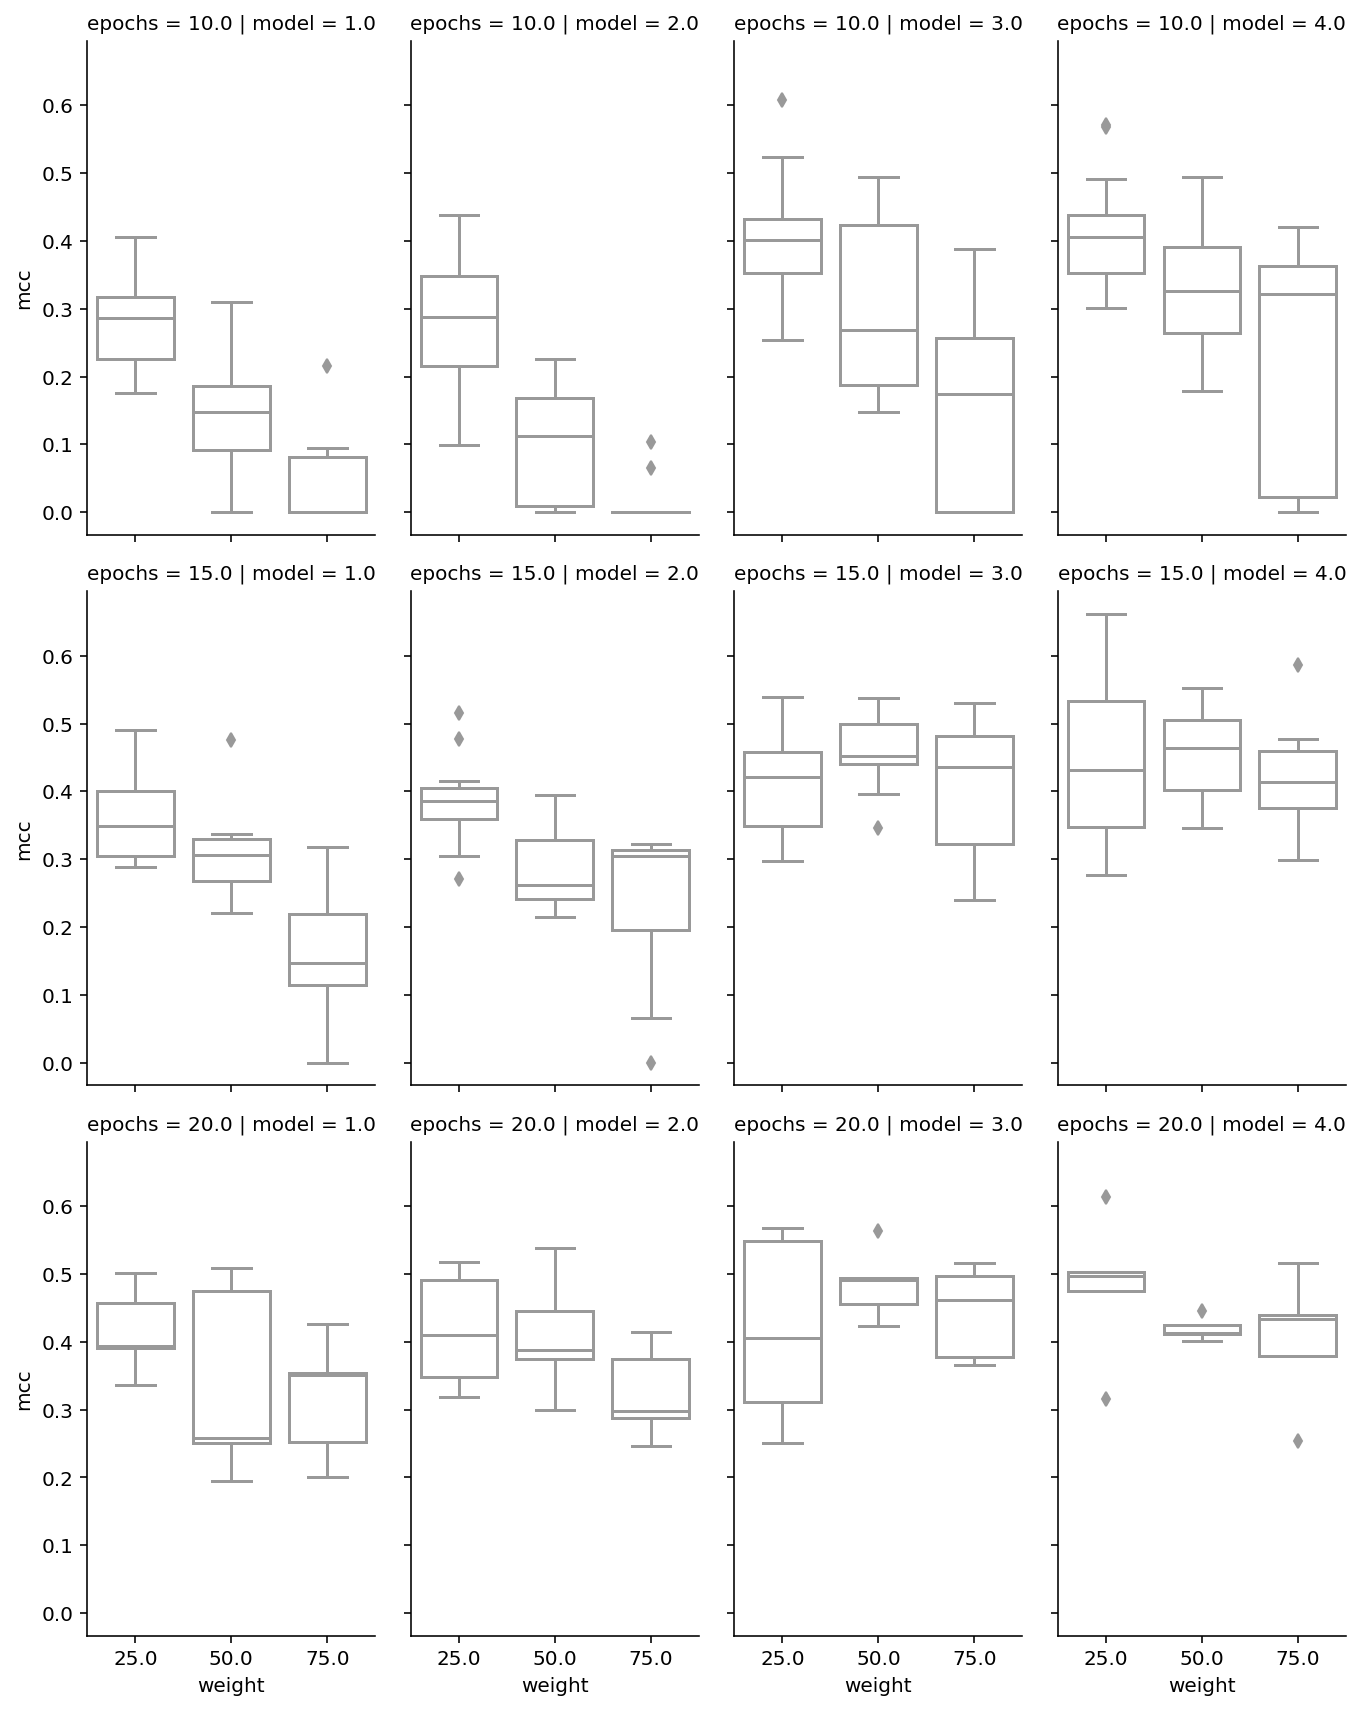

In [32]:
g = sns.FacetGrid(results, col='model', row='epochs', sharey=True, height=4, aspect=0.6)
g = g.map(sns.boxplot, 'weight', 'mcc', color='w')

In [50]:
results.groupby(['model', 'epochs', 'weight']).agg({'low confidence': ['mean', 'std'], 
                                                    'auc': ['mean', 'std'], 
                                                    'mcc': ['mean', 'std']}).sort_values(('mcc', 'mean'), ascending=False)

low confidence                 auc                 mcc  \
                              mean       std      mean       std      mean   
model epochs weight                                                          
3.0   20.0   50.0         0.167344  0.051254  0.737778  0.035729  0.485552   
4.0   20.0   25.0         0.100202  0.034820  0.734220  0.049121  0.481199   
3.0   15.0   50.0         0.259617  0.066987  0.730307  0.036607  0.456808   
4.0   15.0   50.0         0.236673  0.143269  0.737440  0.042993  0.454510   
             25.0         0.143922  0.040852  0.720890  0.060687  0.444182   
3.0   20.0   75.0         0.260578  0.083150  0.737650  0.038344  0.443714   
4.0   20.0   50.0         0.115482  0.044017  0.701375  0.028881  0.418930   
      15.0   75.0         0.496602  0.255385  0.737249  0.044499  0.417827   
3.0   15.0   25.0         0.197096  0.033851  0.698868  0.040821  0.417011   
2.0   20.0   25.0         0.327651  0.139582  0.719169  0.035817  0.416922   
3.0   20.0   25.0         0.169829  0.055810  0.694733  0.067507  0.416857   
1.0   20.0   25.0         0.271243  0.058385  0.706247  0.024154  0.415891   
4.0   10.0   25.0         0.393882  0.205492  0.726784  0.044057  0.412132   
2.0   20.0   50.0         0.478649  0.085379  0.733832  0.047864  0.409044   
3.0   15.0   75.0         0.404531  0.208270  0.713418  0.041855  0.406033   
4.0   20.0   75.0         0.198037  0.058832  0.717079  0.052169  0.404332   
3.0   10.0   25.0         0.531436  0.171361  0.723041  0.048412  0.404277   
2.0   15.0   25.0         0.552338  0.131000  0.720104  0.034645  0.383744   
1.0   15.0   25.0         0.506036  0.136841  0.700353  0.041666  0.361069   
      20.0   50.0         0.498622  0.163845  0.681453  0.082529  0.337379   
4.0   10.0   50.0         0.625014  0.136929  0.677715  0.062537  0.326071   
2.0   20.0   75.0         0.531681  0.168991  0.688772  0.046396  0.324420   
1.0   20.0   75.0         0.597891  0.074120  0.686107  0.066897  0.316901   
      15.0   50.0         0.689937  0.096300  0.679137  0.045198  0.308152   
3.0   10.0   50.0         0.676495  0.092488  0.665264  0.092536  0.300955   
2.0   15.0   50.0         0.712037  0.050119  0.664750  0.038442  0.282446   
      10.0   25.0         0.787190  0.051466  0.658415  0.070591  0.278157   
1.0   10.0   25.0         0.832156  0.053640  0.660511  0.049382  0.277269   
2.0   15.0   75.0         0.643036  0.151869  0.635258  0.076085  0.238663   
4.0   10.0   75.0         0.540337  0.161062  0.628404  0.108894  0.224590   
1.0   15.0   75.0         0.583873  0.089827  0.568271  0.052844  0.156539   
3.0   10.0   75.0         0.546197  0.190114  0.582427  0.084783  0.153217   
1.0   10.0   50.0         0.689724  0.101646  0.570686  0.064083  0.148351   
2.0   10.0   50.0         0.585282  0.145264  0.540244  0.041919  0.099421   
1.0   10.0   75.0         0.428586  0.198090  0.514586  0.027891  0.046311   
2.0   10.0   75.0         0.347738  0.172957  0.502753  0.006409  0.016804   

                               
                          std  
model epochs weight            
3.0   20.0   50.0    0.052323  
4.0   20.0   25.0    0.106820  
3.0   15.0   50.0    0.057777  
4.0   15.0   50.0    0.071241  
             25.0    0.116472  
3.0   20.0   75.0    0.068608  
4.0   20.0   50.0    0.016887  
      15.0   75.0    0.080864  
3.0   15.0   25.0    0.072261  
2.0   20.0   25.0    0.086752  
3.0   20.0   25.0    0.140544  
1.0   20.0   25.0    0.063989  
4.0   10.0   25.0    0.081379  
2.0   20.0   50.0    0.088711  
3.0   15.0   75.0    0.106022  
4.0   20.0   75.0    0.097596  
3.0   10.0   25.0    0.089375  
2.0   15.0   25.0    0.065250  
1.0   15.0   25.0    0.069323  
      20.0   50.0    0.143464  
4.0   10.0   50.0    0.105302  
2.0   20.0   75.0    0.068737  
1.0   20.0   75.0    0.089969  
      15.0   50.0    0.070019  
3.0   10.0   50.0    0.134765  
2.0   15.0   50.0    0.060221  
      10.0   25.0    0.101024  
1.0   10.0   25.0

In [33]:
model = build_model4()
        
model.fit(X_train, y_train, epochs=20, class_weight={0: 25.0, 1: 1.0}, verbose=1)

p = model.predict(X_test)

Epoch 1/20
873/873 [==============================] - 73s 84ms/step - loss: 2.5679 - f1: 0.8730
Epoch 2/20
873/873 [==============================] - 3s 3ms/step - loss: 2.2062 - f1: 0.8739
Epoch 3/20
873/873 [==============================] - 3s 3ms/step - loss: 1.9617 - f1: 0.8732
Epoch 4/20
873/873 [==============================] - 3s 4ms/step - loss: 1.6651 - f1: 0.8736
Epoch 5/20
873/873 [==============================] - 3s 4ms/step - loss: 1.2653 - f1: 0.8739
Epoch 6/20
873/873 [==============================] - 3s 3ms/step - loss: 0.8687 - f1: 0.8740
Epoch 7/20
873/873 [==============================] - 3s 3ms/step - loss: 0.4862 - f1: 0.8733
Epoch 8/20
873/873 [==============================] - 3s 3ms/step - loss: 0.3733 - f1: 0.8737
Epoch 9/20
873/873 [==============================] - 3s 3ms/step - loss: 0.2801 - f1: 0.8733
Epoch 10/20
873/873 [==============================] - 3s 3ms/step - loss: 0.1091 - f1: 0.8736
Epoch 11/20
873/873 [==============================] - 3s

In [34]:
pd.crosstab(y_test, p.argmax(axis=1), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,32,16,48
1,19,152,171
All,51,168,219


In [35]:
print(metrics.classification_report(y_test, p.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65        48
           1       0.90      0.89      0.90       171

   micro avg       0.84      0.84      0.84       219
   macro avg       0.77      0.78      0.77       219
weighted avg       0.84      0.84      0.84       219



### Confidence

In [51]:
res = []

for trial in range(6):
        
    kfold = KFold(n_splits=5, shuffle=True)

    for fold, (training_ixs, validation_ixs) in enumerate(kfold.split(embedded_fragments)):

        model = build_model4()

        model.fit(embedded_fragments[training_ixs], y_data[training_ixs], epochs=20, class_weight={0: 25.0, 1: 1.0}, verbose=0)

        p = model.predict(embedded_fragments[validation_ixs])
        del model
        
        res.append([p.argmax(axis=1), y_data[validation_ixs], len(validation_ixs)])
        del p

        print(f'[{datetime.now()}] Trial [{trial+1}][{fold+1}] complete')

[2019-02-11 07:18:06.476062] Trial [1][1] complete
[2019-02-11 07:19:56.330293] Trial [1][2] complete
[2019-02-11 07:21:42.701433] Trial [1][3] complete
[2019-02-11 07:23:30.049585] Trial [1][4] complete
[2019-02-11 07:25:19.242919] Trial [1][5] complete
[2019-02-11 07:27:11.876893] Trial [2][1] complete
[2019-02-11 07:29:03.313358] Trial [2][2] complete
[2019-02-11 07:30:56.229813] Trial [2][3] complete
[2019-02-11 07:32:52.629011] Trial [2][4] complete
[2019-02-11 07:34:49.521487] Trial [2][5] complete
[2019-02-11 07:36:45.373842] Trial [3][1] complete
[2019-02-11 07:38:44.146734] Trial [3][2] complete
[2019-02-11 07:40:54.551055] Trial [3][3] complete
[2019-02-11 07:42:55.929113] Trial [3][4] complete
[2019-02-11 07:50:30.893173] Trial [3][5] complete
[2019-02-11 07:52:42.541249] Trial [4][1] complete
[2019-02-11 07:54:56.550729] Trial [4][2] complete
[2019-02-11 07:57:05.231188] Trial [4][3] complete
[2019-02-11 07:59:22.067378] Trial [4][4] complete
[2019-02-11 08:20:37.201315] Tr

In [52]:
z = []

for r in res:
    auc = metrics.roc_auc_score(r[1], r[0])
    mcc = metrics.matthews_corrcoef(r[1], r[0])
    
    z.append([r[2], auc, mcc])
    
z = np.array(z)

In [53]:
r = pd.DataFrame(z, columns=['total', 'auc', 'mcc'])

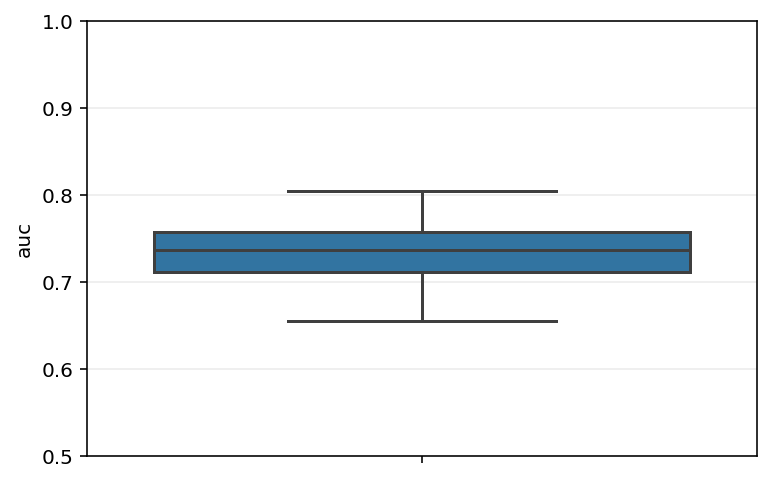

In [54]:
sns.boxplot(y='auc', data=r)
plt.ylim([0.5,1])
plt.grid(axis='y', alpha=0.25);

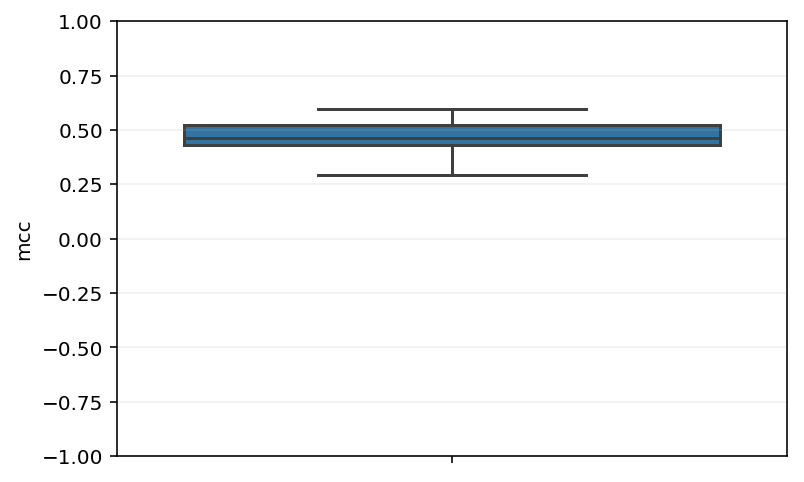

In [57]:
sns.boxplot(y='mcc', data=r)
plt.ylim([-1,1])
plt.grid(axis='y', alpha=0.2);

In [ ]:
add "fight for his life" using the idea of a battle to talk about going against cancer